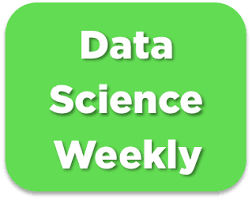

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [96]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from xgboost import XGBClassifier
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [97]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


# Application des même préprocess 

In [98]:
valeur_palier_haut = data['age'].mean() + 3*data['age'].std()
valeur_palier_bas = data['age'].mean() - 3*data['age'].std()
outlier_condition = (data['age'] > valeur_palier_haut) | (data['age'] < valeur_palier_bas)
data = data[~outlier_condition]
data_sample = data.sample(10000)

In [99]:
target_variable = 'converted'
features_list = data.drop(columns=[target_variable]).columns
numeric_indices = [0]
categorical_indices = []


In [100]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]
data['convert2'] = str(data['converted']>0)
to_stratify = data['country']+ data['convert2']+data["source"] 

In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=to_stratify)

numeric_features = ['age','total_pages_visited']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

categorical_features = ['country','new_user','source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## Modèle XGBoost : 
C'est un algorithme d’ensemble basé sur les arbres de décision.

Il construit une série d’arbres de manière itérative : chaque nouvel arbre corrige les erreurs des arbres précédents.

L’algorithme utilise le gradient boosting, qui optimise une fonction de perte (ici adaptée pour la classification binaire) et permet de réduire le sur-apprentissage grâce à la régularisation.

XGBoost nous permet de tester un modèle robuste capable de combiner précision et recall sur les conversions, tout en offrant des leviers (hyperparamètres) pour maximiser le F1-score.

In [102]:

xgboost = XGBClassifier()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('xgboost', xgboost)])
params = {
    'xgboost__max_depth': [6, 8, 10],
    'xgboost__min_child_weight': [10, 15, 20],
    'xgboost__n_estimators': [16, 18, 20],
}
print(params)
gridsearch = GridSearchCV(
    pipeline, param_grid=params, cv=6
)

gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)


{'xgboost__max_depth': [6, 8, 10], 'xgboost__min_child_weight': [10, 15, 20], 'xgboost__n_estimators': [16, 18, 20]}
Best hyperparameters :  {'xgboost__max_depth': 8, 'xgboost__min_child_weight': 15, 'xgboost__n_estimators': 18}


Le GridSearchCV permet d'identifier les meilleurs hyperparamètres pour notre modèle en testant toutes les combinaisons possibles dans les params définit. Après évaluation par validation croisée, les meilleurs hyperparamètres sont récupèrés. Nous allons les utiliser pour entrainer le modèle final.

In [103]:
params = {
 "max_depth": 8,"min_child_weight": 15,"n_estimators": 18
}
xgboost1 = XGBClassifier(**params)
model_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('xgboost', xgboost1)])

print(params)

model_xgb.fit(X_train, Y_train)

{'max_depth': 8, 'min_child_weight': 15, 'n_estimators': 18}


,steps,"[('preprocessor', ...), ('xgboost', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [104]:


Y_train_pred = model_xgb.predict(X_train)
Y_test_pred = model_xgb.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))



f1-score on train set :  0.7671324463461924
f1-score on test set :  0.7664531158998252


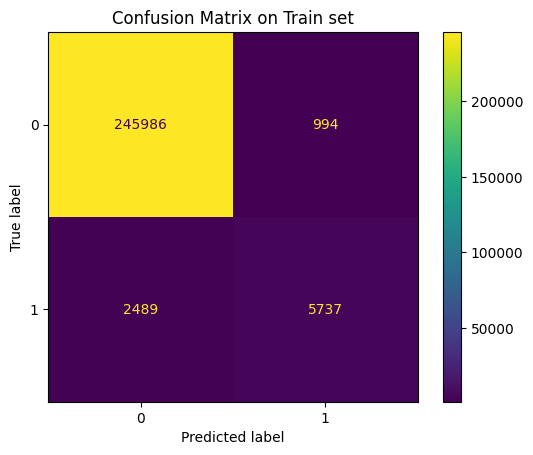

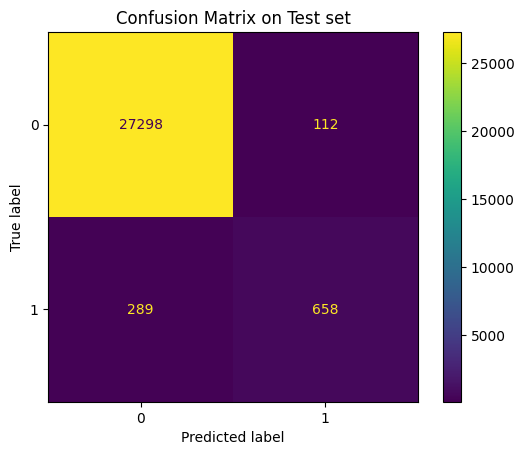

In [105]:
# Visualisation de la matrice de confusion
_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Train set"
)  
ConfusionMatrixDisplay.from_estimator(
    model_xgb, X_train, Y_train, ax=ax
)  
plt.show()

_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix on Test set"
)  
ConfusionMatrixDisplay.from_estimator(
    model_xgb, X_test, Y_test, ax=ax
)  
plt.show()


In [106]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))

print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))


Confusion matrix on train set : 
[[245986    994]
 [  2489   5737]]
Confusion matrix on test set : 
[[27298   112]
 [  289   658]]


### Analyse

* Vrais négatifs (TN) :

LogReg = 27 200

XGBoost = 27 298
XGBoost prédit un peu mieux les non-conversions, qui est la classe majoritaire.

* Faux positifs (FP = faux convertis) :

LogReg = 166

XGBoost = 112
XGBoost fait moins d’erreurs en prédisant une conversion là où il n’y en a pas.
meilleure précision sur la classe 1.

* Faux négatifs (FN = conversions manquées) :

LogReg = 266

XGBoost = 289
LogReg détecte plus de conversions (moins de pertes).
meilleur recall sur la classe 1.

* Vrais positifs (TP = conversions bien détectées) :

LogReg = 725

XGBoost = 658
LogReg trouve plus de conversions réelles.

### Conclusion

Régression logistique : plus de conversions détectées → meilleur recall → F1-score potentiellement plus élevé.

XGBoost : plus sélectif → meilleure précision, mais au prix d’un rappel plus bas (donc F1 plus limité).

Dans une logique d’optimisation du F1-score sur les conversions, la régression logistique reste meilleure pour l’instant.

## Entraînement du modèle sur l’ensemble des données pour la prédiction finale

In [107]:
# On concatene notre ensemble d'entraînement et notre ensemble de test pour entraîner notre meilleur modèle sur toutes les données avec étiquettes
X = pd.concat([X_train,X_test],axis=0)
Y = pd.concat([Y_train,Y_test])

model_xgb.fit(X,Y)

,steps,"[('preprocessor', ...), ('xgboost', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# On charge les données sans étiquettes et on prédit les étiquettes avec notre meilleur XGBclassifier
data_without_labels = pd.read_csv('conversion_data_test.csv')

X_without_labels = data_without_labels.loc[:, features_list]

Y_pred = model_xgb.predict(X_without_labels)

data = {'converted': Y_pred}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
# Y_predictions.to_csv('conversion_data_test_predictions_MARC-XGBclass3.csv', index=False)
